Васильев Г.М. ББМО-02-23

Практика 2: Исследование атак на модели ИИ. Fast
Gradient Sign Method (FGSM)

Обученную модель 'mnist_model.h5' для загрузки в код можно найти в репозитории перейдя по ссылке: https://github.com/Archangel15520/AZSII-REPO/blob/main/README.md

Цель задания:


Познакомиться с одной из популярных атак на системы машинного обучения — атакой Fast Gradient
Sign Method (FGSM). Задача — научиться использовать FGSM для создания противоречивых (adversarial)
примеров, которые могут ввести обученную модель в заблуждение.

В коде используется ранее обученная модель на датасете MNIST

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9736 - loss: 0.0847
Test accuracy on clean images: 0.977400004863739


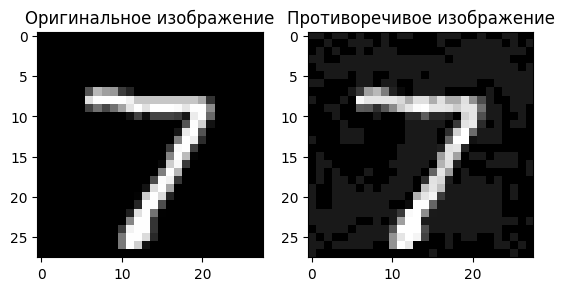

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0660 - loss: 7.0068
Точность на состязательных примерах: 0.08540000021457672
Проверьте точность на чистых изображениях: 0.977400004863739
Точность на состязательных примерах: 0.08540000021457672


In [ ]:
# Подключение к Google Drive для загрузки модели
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# Подключение Google Drive
#drive.mount('/content/drive')

# Шаг 1: Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в one-hot encoding
test_labels_one_hot = to_categorical(test_labels, 10)

# Преобразование изображений в 4-мерный тензор для модели (число образцов, высота, ширина, количество каналов)
test_images = test_images.reshape(-1, 28, 28, 1)

# Загрузка обученной модели из Google Drive
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных с one-hot encoded метками
test_loss, test_acc = model.evaluate(test_images, test_labels_one_hot)
print(f'Test accuracy on clean images: {test_acc}')

# Шаг 2: Реализация FGSM
def fgsm_attack(image, epsilon, gradient):
    # Применение знака градиента к изображению
    perturbed_image = image + epsilon * np.sign(gradient)
    # Обрезка значений, чтобы они оставались в пределах [0,1]
    perturbed_image = np.clip(perturbed_image, 0, 1)
    return perturbed_image

# Вычисление градиента и создание противоречивого примера
def generate_adversarial_example(model, image, label, epsilon):
    # Преобразование изображения в формат, подходящий для модели
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)), dtype=tf.float32)
    label = tf.convert_to_tensor(label.reshape((1, 10)), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
        # Получение градиента по отношению к входному изображению
        gradient = tape.gradient(loss, image)

    # Применение FGSM
    adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
    return adversarial_image

# Шаг 3: Пример использования FGSM
epsilon = 0.1  # Величина шума
adversarial_example = generate_adversarial_example(model, test_images[0], test_labels_one_hot[0], epsilon)

# Вывод оригинального и противоречивого изображений
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0].reshape(28, 28), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")
plt.show()

# Шаг 4: Генерация противоречивых примеров для всего набора данных
def generate_adversarial_dataset(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        adversarial_images.append(adv_image)
    return np.array(adversarial_images)

# Генерация противоречивых примеров
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels_one_hot, epsilon)

# Преобразование противоречивых изображений в 4-мерный тензор
adversarial_images = adversarial_images.reshape(-1, 28, 28, 1)

# Оценка модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels_one_hot)
print(f'Точность на состязательных примерах: {adversarial_acc}')

# Шаг 5: Сравнение результатов
print(f'Проверьте точность на чистых изображениях: {test_acc}')
print(f'Точность на состязательных примерах: {adversarial_acc}')


Вывод:

В ходе выполнения практики были успешно сгенерированы противоречивые примеры с использованием метода Fast Gradient Sign Method (FGSM).

Точность модели на обычных данных составила 97.74%, что подтверждает высокую эффективность обученной модели на чистом датасете MNIST.
Точность модели на противоречивых примерах оказалась значительно ниже и составила 8.54%. Это свидетельствует о том, что модель легко вводится в заблуждение при наличии небольших, целенаправленных изменений в входных данных.
Таким образом, результаты демонстрируют, как противоречивые примеры могут существенно снижать производительность нейронной сети, что подчеркивает важность защиты моделей машинного обучения от подобных атак.